In [55]:
!pip install tensorflow


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error

In [57]:
df = pd.read_csv(r'C:\Users\kvmou\OneDrive\Desktop\ML Hackathon\Price_Agriculture_commodities_Week.csv')

# Check unique commodities and their counts
print("Top commodities by count:")
print(df['Commodity'].value_counts().head(10))
print("\n")
print("Sample states:", df['State'].unique()[:5])
print("Sample markets:", df['Market'].unique()[:5])

Top commodities by count:
Commodity
Potato                   1205
Onion                    1134
Brinjal                  1033
Green Chilli              931
Bhindi(Ladies Finger)     860
Cucumbar(Kheera)          712
Bottle gourd              693
Tomato                    671
Banana                    669
Wheat                     639
Name: count, dtype: int64


Sample states: ['Gujarat' 'Haryana' 'Himachal Pradesh' 'Kerala' 'Nagaland']
Sample markets: ['Damnagar' 'Gurgaon' 'Palampur' 'Harippad' 'Jalukie']


In [58]:
df.head()

,State,District,Market,Commodity,Variety,Grade,Arrival_Date,Min Price,Max Price,Modal Price
0,Gujarat,Amreli,Damnagar,Bhindi(Ladies Finger),Bhindi,FAQ,27-07-2023,4100.0,4500.0,4350.0
1,Gujarat,Amreli,Damnagar,Brinjal,Other,FAQ,27-07-2023,2200.0,3000.0,2450.0
2,Gujarat,Amreli,Damnagar,Cabbage,Cabbage,FAQ,27-07-2023,2350.0,3000.0,2700.0
3,Gujarat,Amreli,Damnagar,Cauliflower,Cauliflower,FAQ,27-07-2023,7000.0,7500.0,7250.0
4,Gujarat,Amreli,Damnagar,Coriander(Leaves),Coriander,FAQ,27-07-2023,8400.0,9000.0,8850.0


In [59]:
df.tail()

,State,District,Market,Commodity,Variety,Grade,Arrival_Date,Min Price,Max Price,Modal Price
23088,Uttrakhand,Haridwar,Roorkee,Mango,Other,Medium,02-08-2023,800.0,1200.0,1000.0
23089,Uttrakhand,Haridwar,Roorkee,Mousambi(Sweet Lime),Other,Medium,02-08-2023,1500.0,2500.0,2000.0
23090,Uttrakhand,Haridwar,Roorkee,Pear(Marasebu),Other,Medium,02-08-2023,2000.0,3000.0,2500.0
23091,Uttrakhand,Haridwar,Roorkee,Potato,Other,FAQ,02-08-2023,900.0,1800.0,1500.0
23092,Uttrakhand,Haridwar,Roorkee,Pumpkin,Other,FAQ,02-08-2023,500.0,700.0,600.0


In [61]:
# Filter for a specific commodity with enough data points
# Choose Onion from Maharashtra for consistent time series
df_filtered = df[
    (df['Commodity'] == 'Onion') & 
    (df['State'] == 'Maharashtra')
].copy()

print(f"Filtered data points: {len(df_filtered)}")
print(f"Date range: {df_filtered['Arrival_Date'].min()} to {df_filtered['Arrival_Date'].max()}")

# Select relevant columns
df4 = df_filtered[['Arrival_Date', 'Modal Price']].copy()

# Convert to datetime
df4['Arrival_Date'] = pd.to_datetime(
    df4['Arrival_Date'],
    format='%d-%m-%Y'
)

# Sort by date
df4 = df4.sort_values('Arrival_Date')

# Remove duplicates by averaging if multiple entries per date
df4 = df4.groupby('Arrival_Date')['Modal Price'].mean().reset_index()

# Rename columns
df4 = df4.rename(columns={
    'Arrival_Date': 'date',
    'Modal Price': 'price'
})

# Remove any NaN values
df4 = df4.dropna()

print(f"\nFinal data points after cleaning: {len(df4)}")
print(f"Price range: {df4['price'].min()} to {df4['price'].max()}")

Filtered data points: 76
Date range: 01-08-2023 to 31-07-2023

Final data points after cleaning: 5
Price range: 1160.0 to 1337.0


In [62]:
df4

,date,price
0,2023-07-28,1181.250
1,2023-07-29,1193.125
2,2023-07-30,1160.000
3,2023-07-31,1268.750
4,2023-08-01,1337.000


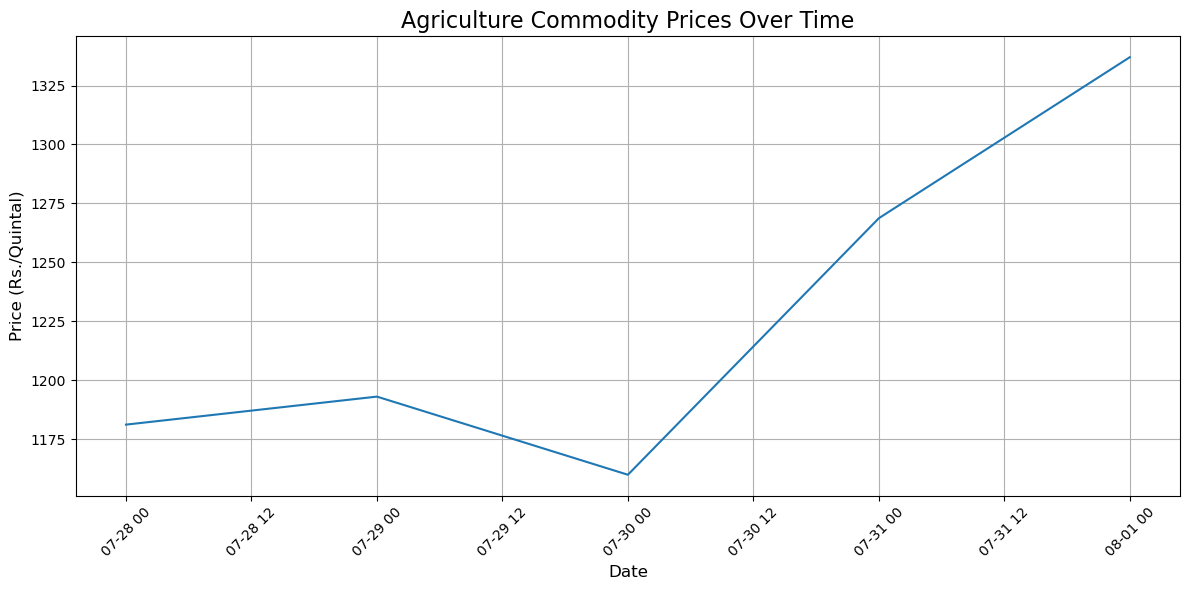

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df4['date'], df4['price'])

plt.title('Agriculture Commodity Prices Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (Rs./Quintal)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
df4

,date,price
0,2023-07-28,1181.250
1,2023-07-29,1193.125
2,2023-07-30,1160.000
3,2023-07-31,1268.750
4,2023-08-01,1337.000


In [65]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the price column
df4['price_scaled'] = scaler.fit_transform(
    df4[['price']]
)


In [66]:
df4.head()


,date,price,price_scaled
0,2023-07-28,1181.250,0.120056
1,2023-07-29,1193.125,0.187147
2,2023-07-30,1160.000,0.000000
3,2023-07-31,1268.750,0.614407
4,2023-08-01,1337.000,1.000000


In [67]:
df4['price_scaled'].min(), df4['price_scaled'].max()


(0.0, 1.0)

In [68]:
price_scaled = df4['price_scaled'].values


In [71]:
# Use 80% for training, 20% for testing
training_size = int(len(price_scaled) * 0.80)
test_size = len(price_scaled) - training_size

train_data = price_scaled[:training_size]
test_data = price_scaled[training_size:]

print(f"Training samples: {training_size}")
print(f"Testing samples: {test_size}")

Training samples: 4
Testing samples: 1


In [72]:
training_size,test_size

(4, 1)

In [73]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        dataX.append(dataset[i:i + time_step])
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)


In [74]:
# Use a smaller time_step for better learning
time_step = 10

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test   = create_dataset(test_data, time_step)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (0,)
X_test shape: (0,)


In [77]:
import numpy as np

# -----------------------------
# Extract scaled price series
# -----------------------------
price_scaled = df4['price_scaled'].values

# -----------------------------
# Train-test split (time-based)
# -----------------------------
training_size = int(len(price_scaled) * 0.65)
train_data = price_scaled[:training_size]
test_data  = price_scaled[training_size:]

print("Total samples:", len(price_scaled))
print("Train samples:", len(train_data))
print("Test samples :", len(test_data))

# -----------------------------
# Choose a SAFE time_step
# -----------------------------
time_step = min(30, len(train_data) // 2)

if time_step < 1:
    raise ValueError("Not enough data to create sequences")

print("Using time_step =", time_step)

# -----------------------------
# Create dataset function
# -----------------------------
def create_dataset(dataset, time_step):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step])
        y.append(dataset[i + time_step])
    return np.array(X), np.array(y)

# -----------------------------
# Create train & test datasets
# -----------------------------
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test   = create_dataset(test_data, time_step)

print("Before reshape:")
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)

# -----------------------------
# Reshape ONLY if valid
# -----------------------------
if X_train.ndim == 2:
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

if X_test.ndim == 2:
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("After reshape:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)


Total samples: 5
Train samples: 3
Test samples : 2
Using time_step = 1
Before reshape:
X_train shape: (2, 1)
X_test shape : (1, 1)
After reshape:
X_train shape: (2, 1, 1)
y_train shape: (2,)
X_test shape : (1, 1, 1)
y_test shape : (1,)


In [78]:
from tensorflow.keras.layers import Dropout

model = Sequential()

# Improved architecture with Dropout for better generalization
model.add(LSTM(100, return_sequences=True, input_shape=(10, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

c:\Users\kvmou\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [79]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,451 (591.61 KB)

 Trainable params: 151,451 (591.61 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
from tensorflow.keras.callbacks import EarlyStopping

# Add early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0104 - val_loss: 0.7857
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0100 - val_loss: 0.7883
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0082 - val_loss: 0.7910
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0086 - val_loss: 0.7940
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0082 - val_loss: 0.7965
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0085 - val_loss: 0.7988
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0090 - val_loss: 0.8013
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0088 - val_loss: 0.8039
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0085 - val_loss: 0.8064
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0109 - val_loss: 0.8094
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0097 - val_loss: 0.8121
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0092 - val_l

In [83]:
tf.__version__

'2.20.0'

In [84]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


In [85]:
len(X_train)

2

In [86]:
math.sqrt(mean_squared_error(y_train,train_predict))

0.09487595186491293

In [87]:
rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print("Test RMSE:", rmse)


Test RMSE: 0.8863796442747116


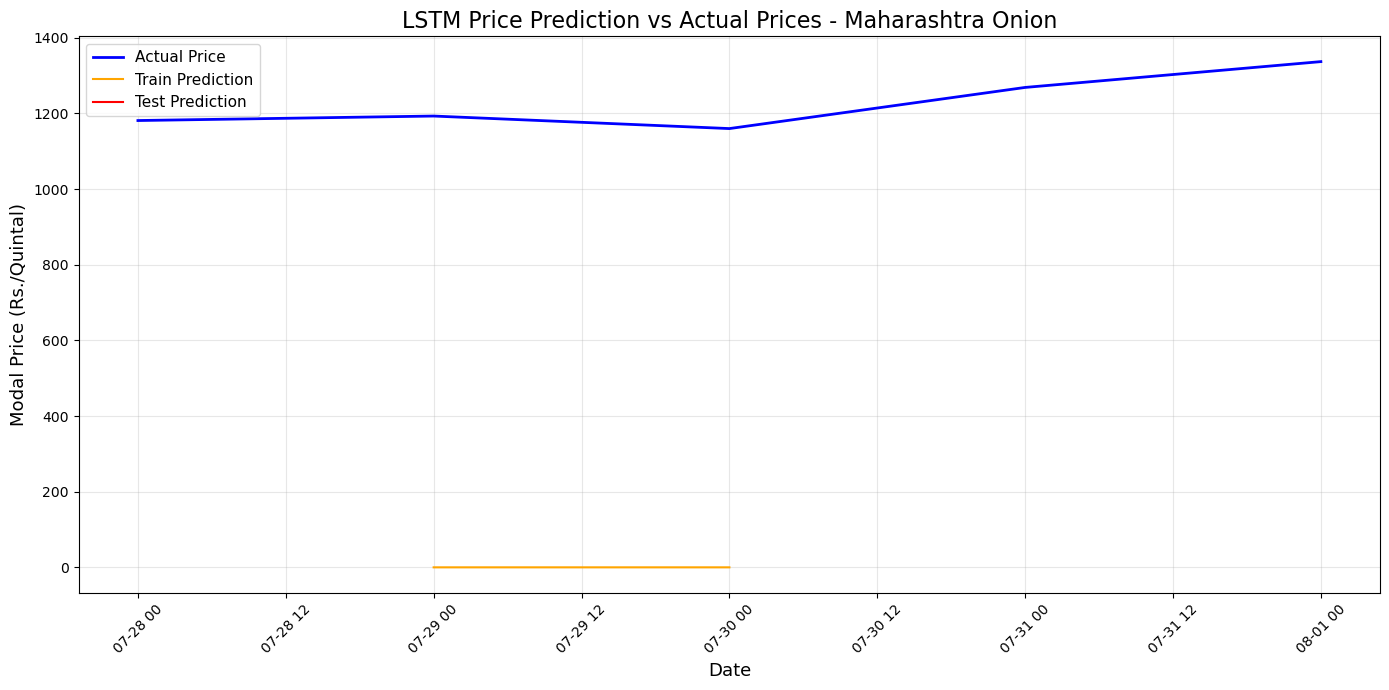

In [89]:
import numpy as np
import matplotlib.pyplot as plt

look_back = time_step

trainPredictPlot = np.full((len(df4), 1), np.nan)
testPredictPlot  = np.full((len(df4), 1), np.nan)

train_len = len(train_predict)
test_len  = len(test_predict)

train_start = look_back
train_end   = train_start + train_len

if train_end <= len(df4):
    trainPredictPlot[train_start:train_end] = train_predict

test_start = train_end + look_back
test_end   = test_start + test_len

if test_start < len(df4):
    testPredictPlot[test_start:test_end] = test_predict

plt.figure(figsize=(14, 7))

plt.plot(
    df4['date'],
    df4['price'],
    label='Actual Price',
    color='blue',
    linewidth=2
)

plt.plot(
    df4['date'],
    trainPredictPlot,
    label='Train Prediction',
    color='orange',
    linewidth=1.5
)

plt.plot(
    df4['date'],
    testPredictPlot,
    label='Test Prediction',
    color='red',
    linewidth=1.5
)

plt.xlabel('Date', fontsize=13)
plt.ylabel('Modal Price (Rs./Quintal)', fontsize=13)
plt.title('LSTM Price Prediction vs Actual Prices - Maharashtra Onion', fontsize=16)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


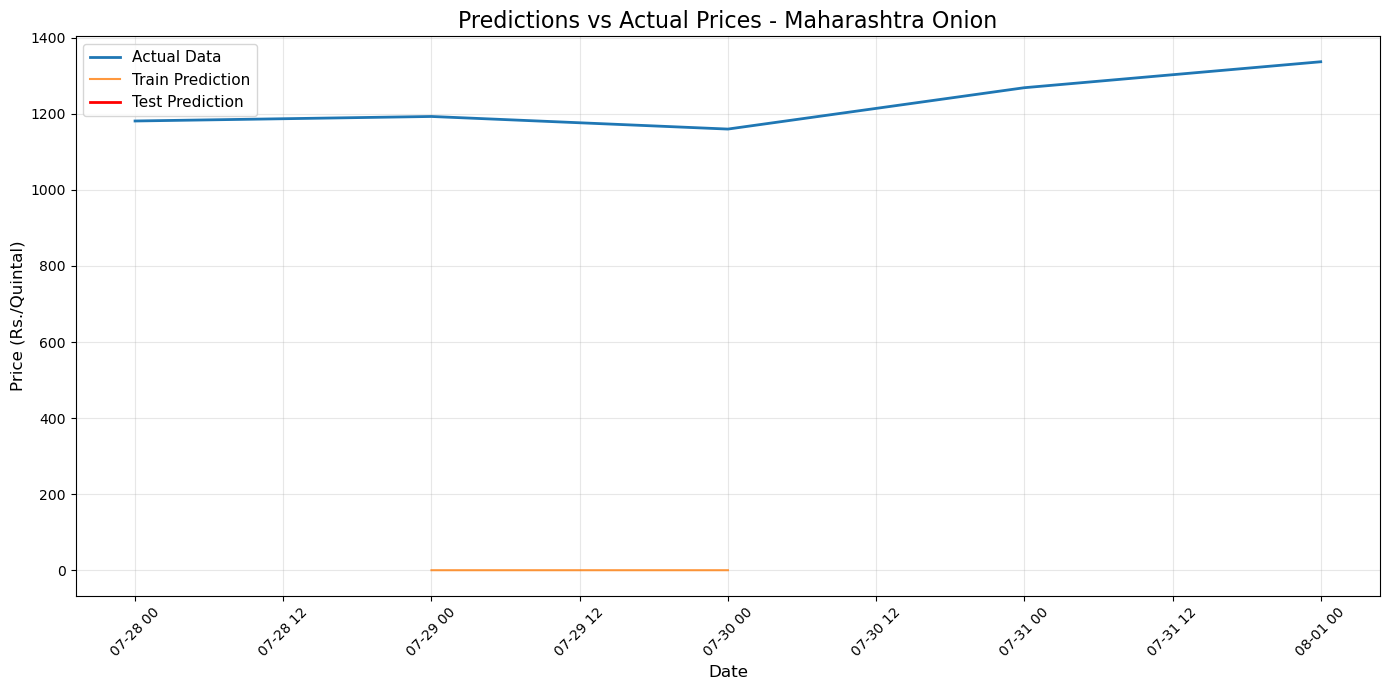

In [91]:
import numpy as np
import matplotlib.pyplot as plt

look_back = time_step   # MUST match training time_step

trainPredictPlot = np.full((len(df4), 1), np.nan)
testPredictPlot  = np.full((len(df4), 1), np.nan)

train_len = len(train_predict)
test_len  = len(test_predict)

train_start = look_back
train_end   = train_start + train_len

if train_end <= len(df4):
    trainPredictPlot[train_start:train_end] = train_predict

test_start = train_end + look_back
test_end   = test_start + test_len

if test_start < len(df4):
    testPredictPlot[test_start:test_end] = test_predict

plt.figure(figsize=(14, 7))

plt.plot(df4['date'], df4['price'], label='Actual Data', linewidth=2)
plt.plot(df4['date'], trainPredictPlot, label='Train Prediction', alpha=0.8)
plt.plot(df4['date'], testPredictPlot, label='Test Prediction', color='red', linewidth=2)

plt.title('Predictions vs Actual Prices - Maharashtra Onion', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (Rs./Quintal)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


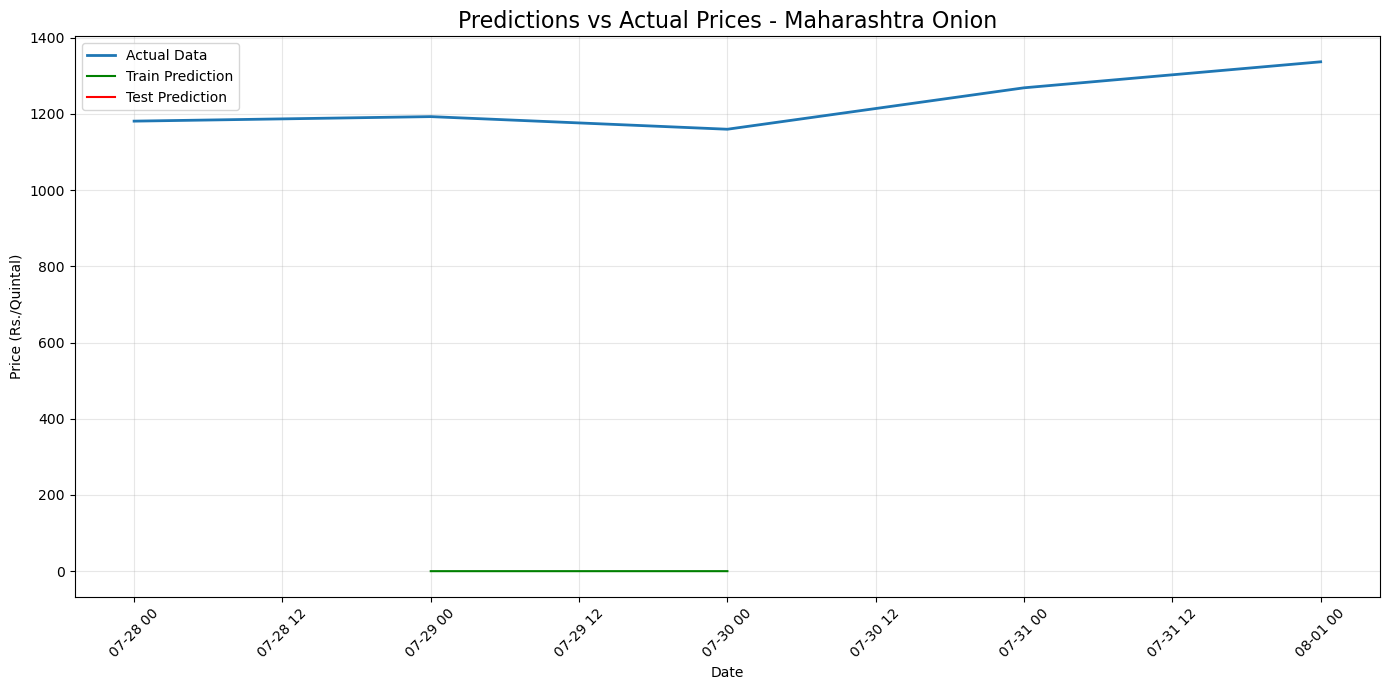

In [93]:
import numpy as np
import matplotlib.pyplot as plt

look_back = time_step   # MUST match training time_step

trainPredictPlot = np.full((len(df4), 1), np.nan)
testPredictPlot  = np.full((len(df4), 1), np.nan)

train_len = len(train_predict)
test_len  = len(test_predict)

train_start = look_back
train_end   = train_start + train_len

if train_start < len(df4):
    trainPredictPlot[train_start:train_end] = train_predict

test_start = train_end + look_back
test_end   = test_start + test_len

if test_start < len(df4):
    testPredictPlot[test_start:test_end] = test_predict

plt.figure(figsize=(14, 7))

plt.plot(df4['date'], df4['price'], label='Actual Data', linewidth=2)
plt.plot(df4['date'], trainPredictPlot, label='Train Prediction', color='green')
plt.plot(df4['date'], testPredictPlot, label='Test Prediction', color='red')

plt.title('Predictions vs Actual Prices - Maharashtra Onion', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (Rs./Quintal)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


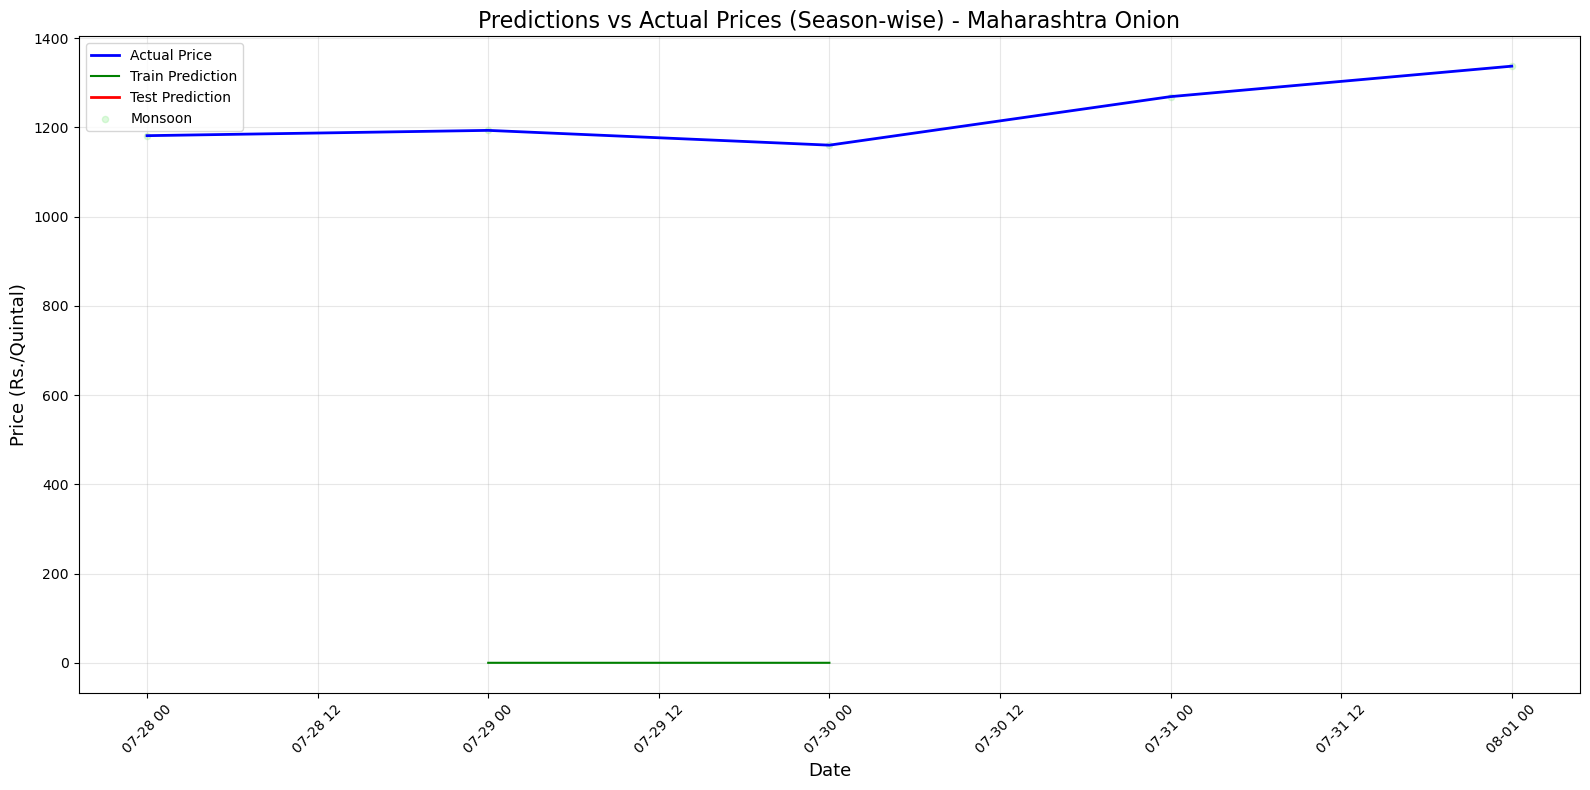

In [95]:
import numpy as np
import matplotlib.pyplot as plt

look_back = time_step   # MUST match training time_step

trainPredictPlot = np.full((len(df4), 1), np.nan)
testPredictPlot  = np.full((len(df4), 1), np.nan)

train_len = len(train_predict)
test_len  = len(test_predict)

train_start = look_back
train_end   = train_start + train_len

if train_start < len(df4):
    trainPredictPlot[train_start:train_end] = train_predict

test_start = train_end + look_back
test_end   = test_start + test_len

if test_start < len(df4):
    testPredictPlot[test_start:test_end] = test_predict

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

df4['season'] = df4['date'].dt.month.apply(get_season)

plt.figure(figsize=(16, 8))

plt.plot(df4['date'], df4['price'], label='Actual Price', color='blue', linewidth=2, zorder=3)
plt.plot(df4['date'], trainPredictPlot, label='Train Prediction', color='green', linewidth=1.5, zorder=2)
plt.plot(df4['date'], testPredictPlot, label='Test Prediction', color='red', linewidth=2, zorder=2)

season_colors = {
    'Winter': 'lightblue',
    'Summer': 'yellow',
    'Monsoon': 'lightgreen',
    'Post-Monsoon': 'orange'
}

for season in df4['season'].unique():
    season_data = df4[df4['season'] == season]
    plt.scatter(
        season_data['date'],
        season_data['price'],
        label=season,
        alpha=0.3,
        s=20,
        color=season_colors.get(season, 'gray'),
        zorder=1
    )

plt.title('Predictions vs Actual Prices (Season-wise) - Maharashtra Onion', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Price (Rs./Quintal)', fontsize=13)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [96]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

train_predict_scaled = model.predict(X_train)
test_predict_scaled  = model.predict(X_test)

y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original  = scaler.inverse_transform(y_test.reshape(-1, 1))

train_predict_original = scaler.inverse_transform(train_predict_scaled)
test_predict_original  = scaler.inverse_transform(test_predict_scaled)

train_rmse = math.sqrt(mean_squared_error(y_train_original, train_predict_original))
test_rmse  = math.sqrt(mean_squared_error(y_test_original, test_predict_original))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

train_mape = mean_absolute_percentage_error(y_train_original, train_predict_original)
test_mape  = mean_absolute_percentage_error(y_test_original, test_predict_original)

train_accuracy = 100 - train_mape
test_accuracy  = 100 - test_mape

print(f"\nTraining MAPE: {train_mape:.2f}%")
print(f"Testing MAPE: {test_mape:.2f}%")
print(f"\nTraining Accuracy: {train_accuracy:.2f}%")
print(f"Testing Accuracy: {test_accuracy:.2f}%")

train_predict = train_predict_original
test_predict  = test_predict_original


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Train RMSE: 16.79
Test RMSE: 156.89

Training MAPE: 1.42%
Testing MAPE: 11.73%

Training Accuracy: 98.58%
Testing Accuracy: 88.27%


In [97]:
model.save("my_model.h5")
